In [1]:
import sys, os, pprint
from IPython.display import HTML, display
import tabulate
sys.path.append(os.path.abspath('../'))
import numpy as np
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.pktselection
import ptp.kalman
import ptp.frequency
import ptp.window
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
filename   = "../data/serial-20190813-185308.json"

In [3]:
reader = ptp.reader.Reader(filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 418560000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_active': 1,
                'n_rru_cfg': 1,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'oscillator': 'xo',
 'start_time': '2019-08-13 18:53:08',
 'sync_period': 0.25}


In [4]:
# Message period in nanoseconds
if (reader.metadata is not None and "sync_period" in reader.metadata):
    T_ns = reader.metadata["sync_period"]*1e9
else:
    T_ns = 1e9/4

In [5]:
# Raw frequency estimations (differentiation of raw time offset measurements)
def frequency(delta=64, optimize=True, drift=True):
    freq_delta     = delta
    freq_estimator = ptp.frequency.Estimator(reader.data, delta=freq_delta)
    freq_estimator.set_truth(delta=freq_delta)
    if (optimize):
        print("Optimizing frequency delta...")
        freq_estimator.optimize()
    
    freq_estimator.process()
    
    if (drift):
        print("Estimating drift...")
        # Estimate time offset drifts due to frequency offset
        freq_estimator.estimate_drift()
    
    return freq_estimator.delta

In [6]:
def optimizer(estimators, data, T, fine_pass=False, method="max-te"):
    window_optimizer = ptp.window.Optimizer(data, T)
    estimations = []
    for e in est:
        window_optimizer.process(e, file=filename, method=method,
                                 plot=False, fine_pass=fine_pass, force=True)
        N        = window_optimizer.est_op[e]["N_best"]
        _, er, _ = window_optimizer._evaluate([N], e, method=method)
        estimations.append([e, N, er])
    
    return estimations

In [7]:
def disp_table(header, table):
    value = header + table
    display(HTML(tabulate.tabulate(value, tablefmt='html')))

In [8]:
# Frequency estimation
delta = frequency()
print(f"Delta: {delta}")

Optimizing frequency delta...
Estimating drift...
Delta: 512


## Test #01: Max|TE| vs MTIE vs MSE

In [9]:
est    = ["ls", "sample-average", "sample-min", "sample-max"]
method = ["max-te", "mtie", "mse"]

for m in method:
    print(f"Method: {m}")
    estimations = optimizer(est, reader.data, T_ns, method=m, fine_pass=True)
    disp_table([["Estimator", "N", "Error"]], estimations)
    print("-----------------------------------------------------\n")

Method: max-te


Estimator,N,Error
ls,35,[1907.2642858]
sample-average,11,[1930.29950374]
sample-min,18,[2121.82926458]
sample-max,15,[2109.41256833]


-----------------------------------------------------

Method: mtie


Estimator,N,Error
ls,31,[1799.57358861]
sample-average,11,[1906.37592494]
sample-min,6,[2106.85774297]
sample-max,2,[2030.35774302]


-----------------------------------------------------

Method: mse


Estimator,N,Error
ls,33,[146261.01454772]
sample-average,15,[139502.1499074]
sample-min,22,[56369.37165206]
sample-max,41,[188700.52369773]


-----------------------------------------------------



## Test #02: Data size vs Best window size

In [10]:
data_len  = np.arange(2, 20, 2)

# Full data
print("Running full data:")
estimations = optimizer(est, reader.data, T_ns, fine_pass=False)
disp_table([["Estimator", "N", "Error"]], estimations)
print("-----------------------------------------------------\n")

# Partial data
print("Running partial data:")
for n in data_len:
    print(f"1/{n} * data:")
    part_data = reader.data[:int(len(reader.data)/n)]
    estimations = optimizer(est, part_data, T_ns, fine_pass=False)
    disp_table([["Estimator", "N", "Error"]], estimations)
    print("-----------------------------------------------------\n")

Running full data:


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,8,[1941.66343111]
sample-min,32,[2121.82926464]
sample-max,8,[2109.41256839]


-----------------------------------------------------

Running partial data:
1/2 * data:


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,8,[1941.66343111]
sample-min,32,[2096.13544422]
sample-max,2,[2030.35774302]


-----------------------------------------------------

1/4 * data:


Estimator,N,Error
ls,16,[1405.56617653]
sample-average,8,[1295.49313241]
sample-min,32,[1387.58872807]
sample-max,16,[1364.35959232]


-----------------------------------------------------

1/6 * data:


Estimator,N,Error
ls,16,[1405.56617653]
sample-average,8,[1283.75413573]
sample-min,32,[1387.58872807]
sample-max,16,[1352.7186799]


-----------------------------------------------------

1/8 * data:


Estimator,N,Error
ls,16,[1268.82720578]
sample-average,8,[1188.58073139]
sample-min,32,[1300.05681974]
sample-max,16,[1191.84198099]


-----------------------------------------------------

1/10 * data:


Estimator,N,Error
ls,16,[1268.82720578]
sample-average,8,[1188.58073139]
sample-min,32,[1300.05681974]
sample-max,8,[1078.02868527]


-----------------------------------------------------

1/12 * data:


Estimator,N,Error
ls,64,[1156.72019213]
sample-average,8,[1188.58073139]
sample-min,32,[1165.8352766]
sample-max,8,[1078.02868527]


-----------------------------------------------------

1/14 * data:


Estimator,N,Error
ls,64,[1156.72019213]
sample-average,8,[1188.58073139]
sample-min,32,[1165.8352766]
sample-max,8,[962.88814032]


-----------------------------------------------------

1/16 * data:


Estimator,N,Error
ls,64,[1156.72019213]
sample-average,8,[1188.58073139]
sample-min,32,[1165.8352766]
sample-max,8,[962.88814032]


-----------------------------------------------------

1/18 * data:


Estimator,N,Error
ls,128,[1014.52997822]
sample-average,8,[1188.58073139]
sample-min,32,[1165.8352766]
sample-max,8,[962.88814032]


-----------------------------------------------------



## Test #03: Frequency vs Window size

### Test #03.1: Frequency vs Window size

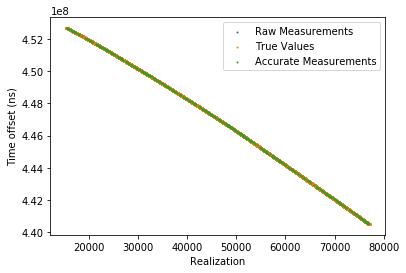

In [11]:
# PTP analyser
analyser = ptp.metrics.Analyser(reader.data)
analyser.plot_toffset_vs_time(save=False, x_unit='samples')

In [12]:
print("Optimized frequency")
delta = frequency()
print("-----------------------------------------------------\n")

print("Using all samples:")
estimations = optimizer(est, reader.data, T_ns)
disp_table([["Estimator", "N", "Error"]], estimations)
print(len(reader.data))
print("-----------------------------------------------------\n")

print("Skiping the samples without drift estimation:")
estimations = optimizer(est, reader.data[delta:], T_ns)
print(len(reader.data[delta:]))
disp_table([["Estimator", "N", "Error"]], estimations)
print("-----------------------------------------------------\n")

Optimized frequency
Optimizing frequency delta...
Estimating drift...
-----------------------------------------------------

Using all samples:


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,8,[1941.66343111]
sample-min,32,[2121.82926464]
sample-max,8,[2109.41256839]


77112
-----------------------------------------------------

Skiping the samples without drift estimation:
76600


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,8,[1941.66343099]
sample-min,32,[2121.82926464]
sample-max,8,[2109.41256839]


-----------------------------------------------------



### Test #03.2: Frequency vs Window size

In [13]:
print("Optimized frequency")
delta = frequency()
print(f"Frequency delta: {delta}")
estimations = optimizer(est, reader.data, T_ns)
disp_table([["Estimator", "N", "Error"]], estimations)
print("-----------------------------------------------------\n")

n_delta = np.arange(2, 10, 2)
for d in n_delta:
    delta = frequency(delta=int(d), optimize=False)
    print(f"Frequency delta: {delta}")
    estimations = optimizer(est, reader.data, T_ns)
    disp_table([["Estimator", "N", "Error"]], estimations)
    print("-----------------------------------------------------\n")

Optimized frequency
Optimizing frequency delta...
Estimating drift...
Frequency delta: 512


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,8,[1941.66343111]
sample-min,32,[2121.82926464]
sample-max,8,[2109.41256839]


-----------------------------------------------------

Estimating drift...
Frequency delta: 2


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,2,[2825.8287046]
sample-min,4,[2869.40542442]
sample-max,2,[2906.88662732]


-----------------------------------------------------

Estimating drift...
Frequency delta: 4


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,256,[2382.31957585]
sample-min,256,[2466.46099186]
sample-max,2,[2532.43326396]


-----------------------------------------------------

Estimating drift...
Frequency delta: 6


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,256,[2324.63101858]
sample-min,1024,[2232.90521276]
sample-max,2,[2672.34472185]


-----------------------------------------------------

Estimating drift...
Frequency delta: 8


Estimator,N,Error
ls,32,[1963.67897707]
sample-average,64,[2162.16044241]
sample-min,256,[2349.87290084]
sample-max,2,[2113.5]


-----------------------------------------------------

